https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [3]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

Connecting to download.pytorch.org (18.244.102.88:443)
saving to 'hymenoptera_data.zip'
hymenoptera_data.zip   0% |                                |  204k  0:03:45 ETA
hymenoptera_data.zip   2% |                                | 1036k  0:01:27 ETA
hymenoptera_data.zip   4% |*                               | 1948k  0:01:08 ETA
hymenoptera_data.zip   5% |*                               | 2668k  0:01:05 ETA
hymenoptera_data.zip   7% |**                              | 3452k  0:01:01 ETA
hymenoptera_data.zip   9% |***                             | 4524k  0:00:55 ETA
hymenoptera_data.zip  12% |***                             | 5740k  0:00:49 ETA
hymenoptera_data.zip  15% |****                            | 7020k  0:00:44 ETA
hymenoptera_data.zip  18% |*****                           | 8556k  0:00:39 ETA
hymenoptera_data.zip  21% |******                          |  9.7M  0:00:36 ETA
hymenoptera_data.zip  25% |********                        | 11.3M  0:00:32 ETA
hymenoptera_data.zip  27% |*****

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg
  inflating: hymenoptera_data/train/ants/1473187633_63ccaacea6.jpg
  in

In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# We want to be able to train our model on an `accelerator <https://pytorch.org/docs/stable/torch.html#accelerators>`__
# such as CUDA, MPS, MTIA, or XPU. If the current accelerator is available, we will use it. Otherwise, we use the CPU.

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


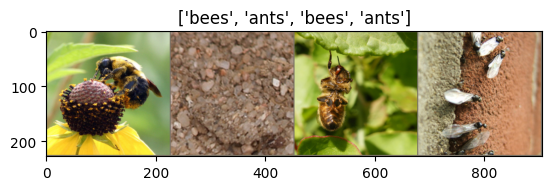

In [6]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
model_ft = models.resnet18(weights='IMAGENET1K_V1') #models.resnet18() для обучения с нуля
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Ivan/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5509 Acc: 0.7090
val Loss: 0.2717 Acc: 0.9150

Epoch 1/24
----------
train Loss: 0.5904 Acc: 0.7705
val Loss: 0.3631 Acc: 0.8627

Epoch 2/24
----------
train Loss: 0.7442 Acc: 0.7172
val Loss: 0.3455 Acc: 0.8824

Epoch 3/24
----------
train Loss: 0.7652 Acc: 0.7377
val Loss: 0.4836 Acc: 0.8170

Epoch 4/24
----------
train Loss: 0.5107 Acc: 0.8156
val Loss: 0.2991 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.5486 Acc: 0.7992
val Loss: 0.3545 Acc: 0.8627

Epoch 6/24
----------
train Loss: 0.5147 Acc: 0.7951
val Loss: 0.6897 Acc: 0.8039

Epoch 7/24
----------
train Loss: 0.3955 Acc: 0.8115
val Loss: 0.2899 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.3228 Acc: 0.8648
val Loss: 0.2607 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.3772 Acc: 0.8484
val Loss: 0.2536 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.3664 Acc: 0.8525
val Loss: 0.2655 Acc: 0.9020

Epoch 11/24
----------
train Loss: 0.3591 Acc: 0.8238
val Loss: 0.2594 Acc: 0.9216

Ep

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

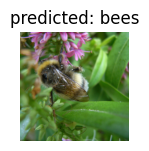

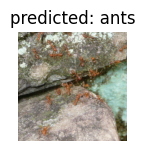

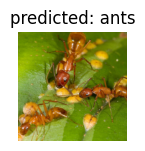

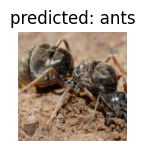

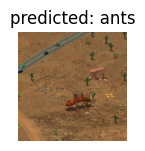

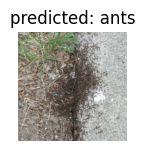

In [11]:
visualize_model(model_ft)

plt.ioff()
plt.show()